In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def pareto_frontier(Xs, Ys, maxX = True, maxY = True):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY


def get_data_mia(filename, hue): 
    data_mia = {'attack1': [], 'attack2': [], 'valperp': [], 'trainperp': [], 'recall1': [], 'recall2': [], 'precision1': [], 'precision2': [], 'gen_gap':[], 'hue':[]}
    with open(filename, 'r') as file:
        count = 0
        last_pos = file.tell()
        f = file.readline()
        while f != '':
            file.seek(last_pos)
            data_point = file.readline().strip()
            if data_point == '*************end of training':
                break
            if data_point == '____':
                count += 1
                data = []
                for i in range(8):
                    data_point = file.readline().strip()
                    if (data_point  != '_____') and data_point != '':
                        data.append(float(data_point))
                data_mia['attack1'].append(data[0])
                data_mia['attack2'].append(data[1])
                data_mia['valperp'].append(data[2])
                data_mia['trainperp'].append(data[3])
                data_mia['recall1'].append(data[4])
                data_mia['recall2'].append(data[5])
                data_mia['precision1'].append(data[6])
                data_mia['precision2'].append(data[7])
                data_mia['gen_gap'].append(data[2]-data[3])
                data_mia['hue'].append(hue)
            
            last_pos = file.tell()
            f = file.readline()
            
    return data_mia
    
    
def get_data_exposure(filename,hue,cnt_s = 20,old=False):
    data_exposure = {'exposure': [] ,'attack1': [], 'valperp': [], 'trainperp': [], 'hue':[]}
    cnt = 0
    with open(filename, 'r') as file:
        last_pos = file.tell()
        f = file.readline()
        while f != '':
            if cnt>cnt_s:
                    break
            file.seek(last_pos)
            data_point = file.readline().strip()
            
            if data_point == 'running canary eval':
                data = []
                data_exposure['exposure'].append(float(file.readline().strip()))
            
            if data_point == '____':
                data = []
                le = 4 if old else 3
                for i in range(le):
                    data_point = file.readline().strip()
                    data.append(float(data_point))
                
                data_exposure['attack1'].append(data[0])
                
                if not old:
                    data_exposure['valperp'].append(data[1])
                    data_exposure['trainperp'].append(data[2])
                else:
                    data_exposure['valperp'].append(data[2])
                    data_exposure['trainperp'].append(data[3])                   
                data_exposure['hue'].append(hue)
                cnt+=1
 
                
            last_pos = file.tell()
            f = file.readline()
            
    return data_exposure


def plot_linear(xlabel,ylabel,title,var,data_mia_head,data_mia_full,data_mia_adapter,data_mia_adapter_red2,f_name):
    plt.figure(figsize=(10, 5))
    ax = sns.lineplot(data=data_mia_head[var],  palette='Set2',linewidth=2.5)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title, xticks=[i+1 for i in range(len(data_mia_head[var]))])
    ax2 = sns.lineplot(data=data_mia_full[var], palette='Set2', linewidth=2.5)
    ax2.set(xlabel=xlabel, ylabel=ylabel, title=title, xticks=[i+1 for i in range(len(data_mia_full[var]))])
    ax2 = sns.lineplot(data=data_mia_adapter[var], palette='Set2', linewidth=2.5)
    ax2.set(xlabel=xlabel, ylabel=ylabel, title=title, xticks=[i+1 for i in range(len(data_mia_adapter[var]))])
    ax2 = sns.lineplot(data=data_mia_adapter_red2[var],  palette='Set2',linewidth=2.5)
    ax2.set(xlabel=xlabel, ylabel=ylabel, title=title, xticks=[i+1 for i in range(len(data_mia_adapter_red2[var]))])
    ax2.legend(title='Fine-tuning Method',labels=['Head FT','Full FT','Adapter(16) FT','Adapter(2) FT'])
    plt.savefig(f_name, transparent=True)

    plt.show()

def plot_scatter(xlabel,ylabel,title,hue,legendtitle,df_all,f_name,pareto=False, xy=(0,0), xytext=(0,0)):
    
    
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    sns.set(rc={"font.size":18, "font.family": "serif", 
                "axes.titlesize":18,"axes.labelsize":18, "ytick.labelsize":18, 
                 "xtick.labelsize":18 , 'legend.fontsize':18, 'legend.title_fontsize': 18}, style="white")
    
    p_front = pareto_frontier(list(df_all[xlabel]), list(df_all[ylabel]), maxX = False, maxY = False) 

    plt.figure(figsize=(10,6), tight_layout=True)
    ax = sns.scatterplot(data=df_all, x=xlabel, y=ylabel,hue=hue, palette='Set2', s=60)
    ax.set(xlabel=xlabel,title=title, ylabel=ylabel)
    ax.legend(title=legendtitle)#loc='lower right' 
    if pareto:
        plt.plot(p_front[0], p_front[1], zorder=2, linewidth=8, color='c', alpha=0.2)
        # plt.text(p_front[0][0], p_front[1][0], "Pareto Frontier", horizontalalignment='left', size='medium', color='b')
        ax.annotate("Pareto Frontier",
            xy=xy, xycoords='data',
            xytext=xytext, textcoords='data',
            color='black',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", color='black'),
            )
    plt.savefig(f_name, transparent=True)

    plt.show()

In [45]:
def plot_linear_single(xlabel, ylabel, title, var, data_mia_full, f_name):
    plt.figure(figsize=(10, 5))
    ax = sns.lineplot(data=data_mia_full[var], palette='Set2', linewidth=2.5)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title, xticks=[i+1 for i in range(len(data_mia_full[var]))])
    ax.legend(title='Fine-tuning Method', labels=['Full FT'])
    plt.savefig(f_name, transparent=True)
    plt.show()
    
def plot_scatter_single(xlabel, ylabel, title, df_full, f_name, pareto=False, xy=(0, 0), xytext=(0, 0)):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    sns.set(rc={"font.size": 18, "font.family": "serif",
                "axes.titlesize": 18, "axes.labelsize": 18, "ytick.labelsize": 18,
                "xtick.labelsize": 18, 'legend.fontsize': 18, 'legend.title_fontsize': 18}, style="white")

    if pareto:
        p_front = pareto_frontier(list(df_full[xlabel]), list(df_full[ylabel]), maxX=False, maxY=False)

    plt.figure(figsize=(10, 6), tight_layout=True)
    # print(df_full)
    # print(type(df_full))
    # print(xlabel)
    # print(ylabel)
    ax = sns.scatterplot(data=df_full, x=xlabel, y=ylabel, palette='Set2', s=60)
    ax.set(xlabel=xlabel, title=title, ylabel=ylabel)
    if pareto:
        plt.plot(p_front[0], p_front[1], zorder=2, linewidth=8, color='c', alpha=0.2)
        ax.annotate("Pareto Frontier",
                    xy=xy, xycoords='data',
                    xytext=xytext, textcoords='data',
                    color='black',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3", color='black'),
                    )
    plt.savefig(f_name, transparent=True)
    plt.show()

In [84]:
# data_mia_head = get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/wikipedia/logs/canary_None_5_adapter_False_head_True_layer_None_ref_True_maxlen_1024_red_None_model_gpt2_lr_0.0001_epoch_20_trba_1_acc_8_evba1_data_wikitext/stdout',hue='Head FT')
# data_mia_full=  get_data_mia('wikipedia/logs/canary_None_5_adapter_False_head_False_layer_None_ref_True_maxlen_1024_red_None_model_../model/gpt2_lr_2e-05_epoch_20_trba_1_acc_8_evba1_data_wikitext/stdout', hue = 'Full FT')
# data_mia_full=  get_data_mia('wikipedia/logs/canary_None_5_adapter_False_head_False_layer_None_ref_True_maxlen_1024_red_None_model_GPT2_lr_2e-05_epoch_20_trba_1_acc_8_evba1_data_wikitext/stdout', hue = 'Full FT')
data_mia_full=  get_data_mia('wikipedia/nohup_0.0001.out', hue = 'Full FT')
# data_mia_adapter=  get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/wikipedia/logs/canary_None_5_adapter_True_head_False_layer_None_ref_True_maxlen_1024_red_16_model_gpt2_lr_0.001_epoch_20_trba_1_acc_8_evba1_data_wikitext/stdout', hue = 'Adapter(16) FT')
# data_mia_adapter_red2=  get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/wikipedia/logs/canary_None_5_adapter_True_head_False_layer_None_ref_True_maxlen_1024_red_2_model_gpt2_lr_0.0001_epoch_20_trba_1_acc_8_evba1_data_wikitext/stdout', hue = 'Adapter(2) FT')


# df_head = pd.DataFrame.from_dict(data_mia_head)
df_full = pd.DataFrame.from_dict(data_mia_full)
# df_adapter = pd.DataFrame.from_dict(data_mia_adapter)
# df_adapter_red2 = pd.DataFrame.from_dict(data_mia_adapter_red2)

# df_all= pd.concat([df_head, df_full,df_adapter,df_adapter_red2], axis=0)
df_all= pd.concat([df_full], axis=0)
#data_exposure = get_data_exposure('/home/tr33/Documents/efficient_ft/gen/stdout-exposure')         

In [85]:
print(type(df_all))

<class 'pandas.core.frame.DataFrame'>


In [86]:
#print(data_mia_head)




# Plot

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

<ipython-input-45-a480894f7ce0>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=data_mia_full[var], palette='Set2', linewidth=2.5)


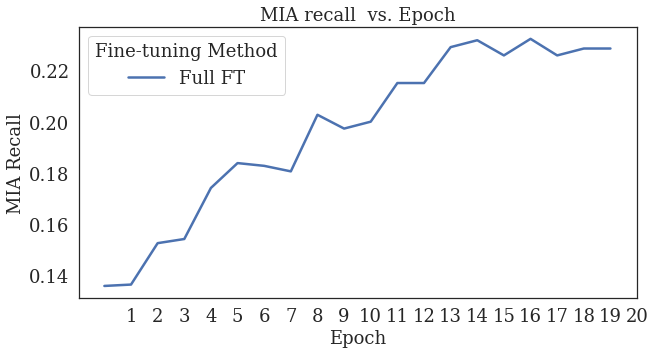

In [88]:

ylabel = 'MIA Recall'
xlabel='Epoch'
title = 'MIA recall  vs. Epoch'
var = 'attack1'
f_name ='wikipedia-mia-epoch.pdf'
# plot_linear(xlabel,ylabel,title,var,data_mia_head,data_mia_full,data_mia_adapter,data_mia_adapter_red2,f_name)
plot_linear_single(xlabel,ylabel,title,var,data_mia_full,f_name)


<ipython-input-45-a480894f7ce0>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=data_mia_full[var], palette='Set2', linewidth=2.5)


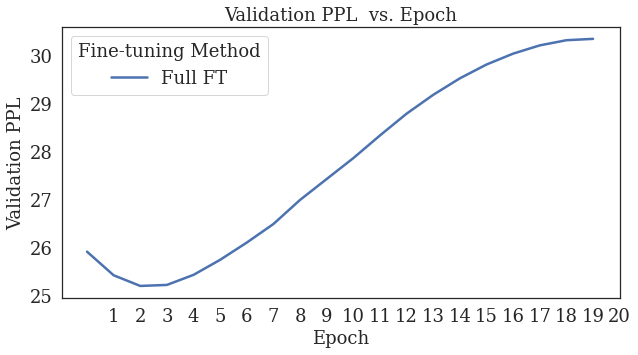

In [89]:

ylabel = 'Validation PPL'
xlabel='Epoch'
title = 'Validation PPL  vs. Epoch'
var = 'valperp'
f_name ='wikipedia-valperp-epoch.pdf'

# plot_linear(xlabel,ylabel,title,var,data_mia_head,data_mia_full,data_mia_adapter,data_mia_adapter_red2,f_name)
plot_linear_single(xlabel,ylabel,title,var,data_mia_full,f_name)



<ipython-input-45-a480894f7ce0>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=data_mia_full[var], palette='Set2', linewidth=2.5)


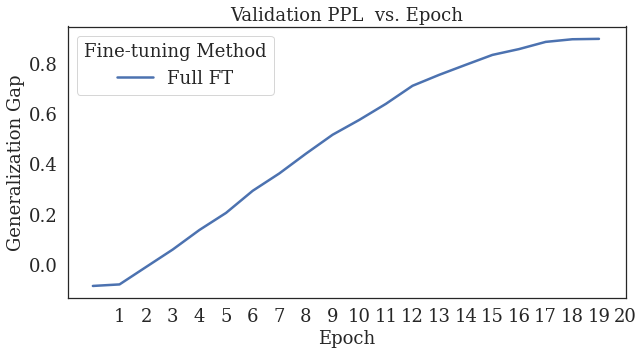

In [90]:

ylabel = 'Generalization Gap'
xlabel='Epoch'
title = 'Validation PPL  vs. Epoch'
var = 'gen_gap'
f_name ='wikipedia-gengap-epoch.pdf'

plot_linear_single(xlabel,ylabel,title,var,data_mia_full,f_name)



<ipython-input-45-a480894f7ce0>:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=df_full, x=xlabel, y=ylabel, palette='Set2', s=60)


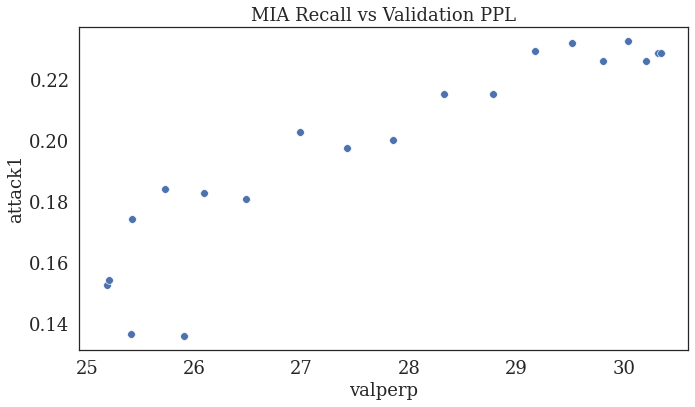

In [91]:
xlabel = 'valperp'
ylabel = 'attack1'
hue = 'hue'
legendtitle = 'Fine-tuning Method'
title= 'MIA Recall vs Validation PPL'
f_name ='wikipedia-mia-valppl-epoch.pdf'


# plot_scatter(xlabel,ylabel,title,hue,legendtitle,df_all,f_name)
plot_scatter_single(xlabel,ylabel,title,df_all,f_name)


<ipython-input-45-a480894f7ce0>:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=df_full, x=xlabel, y=ylabel, palette='Set2', s=60)


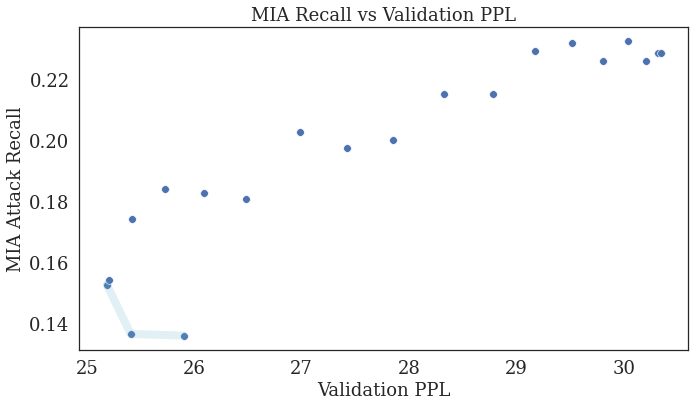

In [92]:
#data = {'X': [13, 13, 13, 12, 11], 'Y':[14, 11, 13, 15, 20], 'NumberOfPlanets':[2, 5, 2, 1, 2]}
#cts = pd.DataFrame(data=data)


df_all['Validation PPL'] =df_all['valperp']
df_all['MIA Attack Recall'] = df_all['attack1']

xlabel = 'Validation PPL'
ylabel = 'MIA Attack Recall'
hue = 'hue'
legendtitle = 'Fine-tuning Method'
title= 'MIA Recall vs Validation PPL'
f_name ='wikipedia-mia-valppl-scatter-pareto.pdf'
# plot_scatter(xlabel,ylabel,title,hue,legendtitle,df_all,f_name,pareto=True, xy=(21.7,0.18), xytext=(22.3,0.35))
plot_scatter_single(xlabel,ylabel,title,df_all,f_name,pareto=True, xy=(21.7,0.18), xytext=(22.3,0.35))


# p_front = pareto_frontier(list(df_all['valperp']), list(df_all['attack1']), maxX = False, maxY = False) 
# #df_all['sum'] = df_all['attack1'] +df_all['valperp']

# #cts = df_all.sort_values('sum')

# plt.figure(figsize=(10,6), tight_layout=True)
# ax = sns.scatterplot(data=df_all, x=xlabel, y=ylabel,hue=hue, palette='Set2', s=60)
# ax.set(xlabel=xlabel,title=title, ylabel=ylabel)
# ax.legend(title=legendtitle, title_fontsize = 12) 

# # plt.figure(figsize=(10,10))
# # plt.scatter(cts['valperp'], cts['attack1'], zorder=1)
# plt.plot(p_front[0], p_front[1], zorder=2, linewidth=8, color='c', alpha=0.2)
# plt.savefig(f_name, transparent=True)
# plt.show()

<ipython-input-45-a480894f7ce0>:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(data=df_full, x=xlabel, y=ylabel, palette='Set2', s=60)


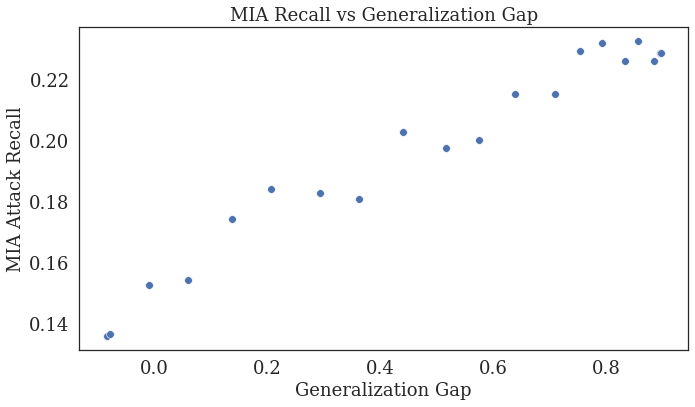

In [93]:

df_all['Generalization Gap'] =df_all['gen_gap']
df_all['MIA Attack Recall'] = df_all['attack1']

xlabel = 'Generalization Gap'
ylabel = 'MIA Attack Recall'


hue = 'hue'
legendtitle = 'Fine-tuning Method'
title= 'MIA Recall vs Generalization Gap'

f_name ='wikipedia-mia-gengap-scatter.pdf'

# plot_scatter(xlabel,ylabel,title,hue,legendtitle,df_all,f_name)
plot_scatter_single(xlabel,ylabel,title,df_all,f_name)


# Cleaned enron

In [15]:
data_mia_head = get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/enron/logs/canary_None_5_adapter_False_head_True_layer_None_ref_True_maxlen_1024_red_None_model_gpt2_lr_0.001_epoch_20_trba_1_acc_8_evba1_data_enron-scrubbed-email-short/stdout',hue='Head FT')
data_mia_full=  get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/enron/logs/canary_None_5_adapter_False_head_False_layer_None_ref_True_maxlen_1024_red_None_model_gpt2_lr_2e-05_epoch_20_trba_1_acc_8_evba1_data_enron-scrubbed-email-short/stdout', hue = 'Full FT')
data_mia_adapter=  get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/enron/logs/canary_None_5_adapter_True_head_False_layer_None_ref_True_maxlen_1024_red_16_model_gpt2_lr_0.001_epoch_20_trba_1_acc_8_evba1_data_enron-scrubbed-email-short/stdout', hue = 'Adapter(16) FT')
data_mia_adapter_red2=  get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/enron/logs/canary_None_5_adapter_True_head_False_layer_None_ref_True_maxlen_1024_red_2_model_gpt2_lr_0.0001_epoch_20_trba_1_acc_8_evba1_data_enron-scrubbed-email-short/stdout', hue = 'Adapter(2) FT')

print(len(data_mia_adapter['attack1']),len(data_mia_adapter_red2['attack1']),len(data_mia_full['attack1']),len(data_mia_head['attack1']))
df_head = pd.DataFrame.from_dict(data_mia_head)
df_full = pd.DataFrame.from_dict(data_mia_full)
df_adapter = pd.DataFrame.from_dict(data_mia_adapter)
df_adapter_red2 = pd.DataFrame.from_dict(data_mia_adapter_red2)

df_all= pd.concat([df_head, df_full,df_adapter,df_adapter_red2], axis=0)

20 20 20 20


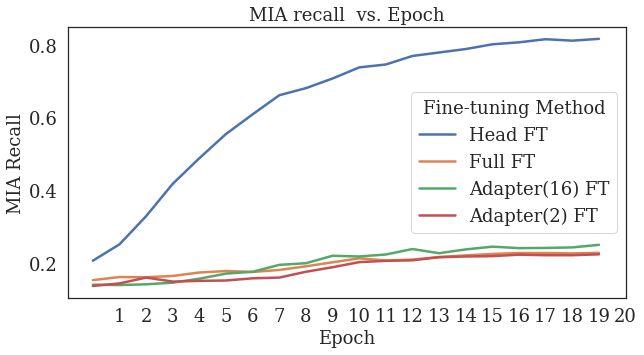

In [16]:

ylabel = 'MIA Recall'
xlabel='Epoch'
title = 'MIA recall  vs. Epoch'
var = 'attack1'
f_name ='enron-mia-epoch.pdf'

plot_linear(xlabel,ylabel,title,var,data_mia_head,data_mia_full,data_mia_adapter,data_mia_adapter_red2,f_name)

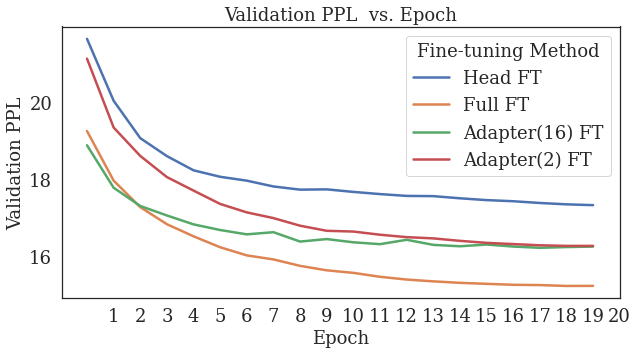

In [17]:

ylabel = 'Validation PPL'
xlabel='Epoch'
title = 'Validation PPL  vs. Epoch'
var = 'valperp'

f_name ='enron-valperp-epoch.pdf'

plot_linear(xlabel,ylabel,title,var,data_mia_head,data_mia_full,data_mia_adapter,data_mia_adapter_red2,f_name)



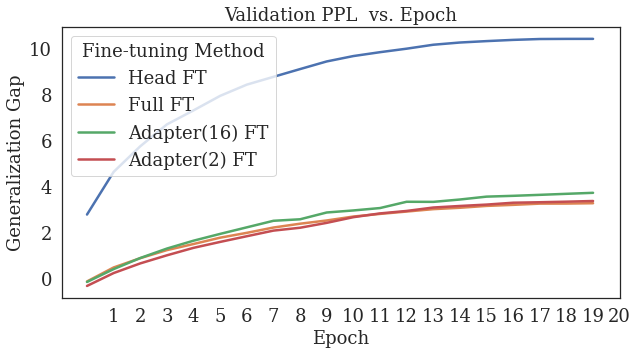

In [18]:

ylabel = 'Generalization Gap'
xlabel='Epoch'
title = 'Validation PPL  vs. Epoch'
var = 'gen_gap'


f_name ='enron-gengap-epoch.pdf'

plot_linear(xlabel,ylabel,title,var,data_mia_head,data_mia_full,data_mia_adapter,data_mia_adapter_red2,f_name)



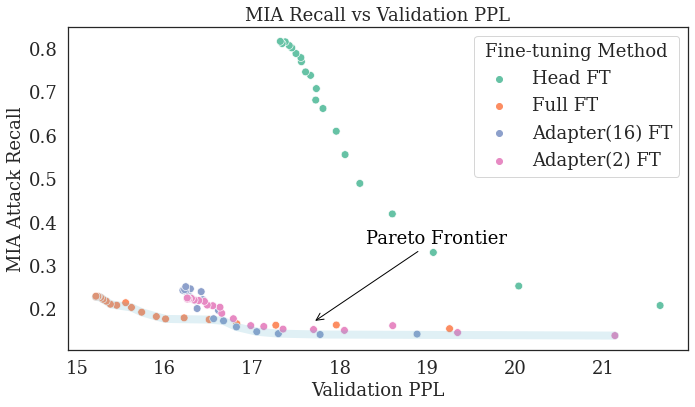

In [31]:

df_all['Validation PPL'] =df_all['valperp']
df_all['MIA Attack Recall'] = df_all['attack1']

xlabel = 'Validation PPL'
ylabel = 'MIA Attack Recall'
hue = 'hue'
legendtitle = 'Fine-tuning Method'
title= 'MIA Recall vs Validation PPL'
f_name ='enron-mia-valppl-scatter-pareto.pdf'


plot_scatter(xlabel,ylabel,title,hue,legendtitle,df_all,f_name,pareto=True, xy=(17.7,0.17), xytext=(18.3,0.35))


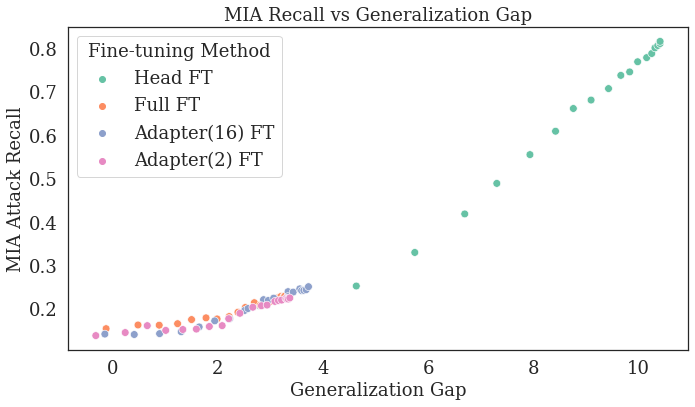

In [32]:

df_all['Generalization Gap'] =df_all['gen_gap']
df_all['MIA Attack Recall'] = df_all['attack1']

xlabel = 'Generalization Gap'
ylabel = 'MIA Attack Recall'


hue = 'hue'
legendtitle = 'Fine-tuning Method'
title= 'MIA Recall vs Generalization Gap'

f_name ='enron-mia-gengap-scatter.pdf'

plot_scatter(xlabel,ylabel,title,hue,legendtitle,df_all,f_name)


# Exposure

In [164]:
data_mia_head = get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/wikipedia/logs/canary_50_6_adapter_False_head_True_layer_None_ref_False_maxlen_1024_red_None_model_gpt2_lr_0.0005_epoch_20_trba_1_acc_8_evba1_data_wikitext/stdout',hue='Head FT')
data_mia_full=  get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/wikipedia/logs/canary_50_6_adapter_False_head_False_layer_None_ref_False_maxlen_1024_red_None_model_gpt2_lr_5e-06_epoch_20_trba_1_acc_8_evba1_data_wikitext/stdout', hue = 'Full FT',old=False)
data_mia_adapter=  get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/wikipedia/logs/canary_50_6_adapter_True_head_False_layer_None_ref_False_maxlen_1024_red_16_model_gpt2_lr_0.0002_epoch_20_trba_1_acc_8_evba1_data_wikitext/stdout', hue = 'Adapter(16) FT',old=False)
data_mia_adapter_red2=  get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/wikipedia/logs/canary_50_6_adapter_True_head_False_layer_None_ref_False_maxlen_1024_red_2_model_gpt2_lr_0.0001_epoch_20_trba_1_acc_8_evba1_data_wikitext/stdout', hue = 'Adapter(2) FT',old=False)

df_head = pd.DataFrame.from_dict(data_mia_head)
df_full = pd.DataFrame.from_dict(data_mia_full)
df_adapter = pd.DataFrame.from_dict(data_mia_adapter)
df_adapter_red2 = pd.DataFrame.from_dict(data_mia_adapter_red2)



df_all= pd.concat([df_head, df_full,df_adapter,df_adapter_red2], axis=0)
#data_exposure = get_data_exposure('/home/tr33/Documents/efficient_ft/gen/stdout-exposure')         

In [33]:
data_mia_head = get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/enron/logs/canary_50_6_adapter_False_head_True_layer_None_ref_False_maxlen_1024_red_None_model_gpt2_lr_0.0005_epoch_20_trba_1_acc_8_evba1_data_enron-email-short/stdout',hue='Head FT')
data_mia_full=  get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/enron/logs/canary_50_6_adapter_False_head_False_layer_None_ref_False_maxlen_1024_red_None_model_gpt2_lr_1e-05_epoch_20_trba_1_acc_8_evba1_data_enron-email-short/stdout', hue = 'Full FT',old=False)
data_mia_adapter=  get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/enron/logs/canary_50_6_adapter_True_head_False_layer_None_ref_False_maxlen_1024_red_16_model_gpt2_lr_0.0004_epoch_20_trba_1_acc_8_evba1_data_enron-email-short/stdout', hue = 'Adapter(16) FT',old=False)
data_mia_adapter_red2=  get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/enron/logs/canary_50_6_adapter_True_head_False_layer_None_ref_False_maxlen_1024_red_2_model_gpt2_lr_0.0001_epoch_20_trba_1_acc_8_evba1_data_enron-email-short/stdout', hue = 'Adapter(2) FT',old=False)

df_head = pd.DataFrame.from_dict(data_mia_head)
df_full = pd.DataFrame.from_dict(data_mia_full)
df_adapter = pd.DataFrame.from_dict(data_mia_adapter)
df_adapter_red2 = pd.DataFrame.from_dict(data_mia_adapter_red2)

df_all= pd.concat([df_head, df_full,df_adapter,df_adapter_red2], axis=0)
#data_exposure = get_data_exposure('/home/tr33/Documents/efficient_ft/gen/stdout-exposure')         

# PTB

In [143]:
data_mia_head = get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/ptb/logs/canary_None_5_adapter_False_head_True_layer_None_ref_True_maxlen_1024_red_None_model_gpt2_lr_0.0008_epoch_20_trba_1_acc_8_evba1_data_ptb_text_only/stdout',hue='Head FT')
data_mia_full=  get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/ptb/logs/canary_None_5_adapter_False_head_False_layer_None_ref_True_maxlen_1024_red_None_model_gpt2_lr_2e-05_epoch_20_trba_1_acc_8_evba1_data_ptb_text_only/stdout', hue = 'Full FT')
data_mia_adapter=  get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/ptb/logs/canary_None_5_adapter_True_head_False_layer_None_ref_True_maxlen_1024_red_16_model_gpt2_lr_0.001_epoch_20_trba_1_acc_8_evba1_data_ptb_text_only/stdout', hue = 'Adapter(16) FT')
data_mia_adapter_red2=  get_data_mia('/home/fmireshg/berglab.projects/efficient_ft/gen/ptb/logs/canary_None_5_adapter_True_head_False_layer_None_ref_True_maxlen_1024_red_2_model_gpt2_lr_0.0002_epoch_20_trba_1_acc_8_evba1_data_ptb_text_only/stdout', hue = 'Adapter(2) FT')

df_head = pd.DataFrame.from_dict(data_mia_head)
df_full = pd.DataFrame.from_dict(data_mia_full)
df_adapter = pd.DataFrame.from_dict(data_mia_adapter)
df_adapter_red2 = pd.DataFrame.from_dict(data_mia_adapter_red2)

df_all= pd.concat([df_head, df_full,df_adapter,df_adapter_red2], axis=0)
#data_exposure = get_data_exposure('/home/tr33/Documents/efficient_ft/gen/stdout-exposure')         

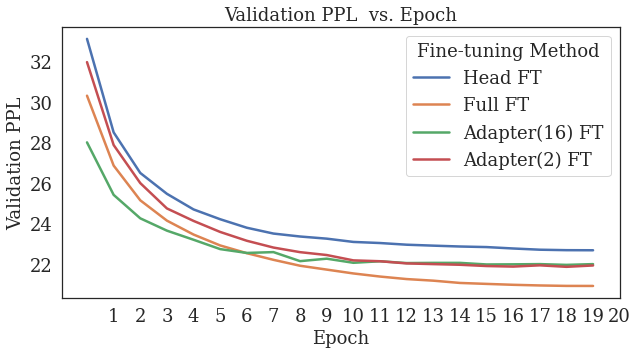

In [145]:

ylabel = 'Validation PPL'
xlabel='Epoch'
title = 'Validation PPL  vs. Epoch'
var = 'valperp'
f_name ='wikipedia-valperp-epoch.pdf'

plot_linear(xlabel,ylabel,title,var,data_mia_head,data_mia_full,data_mia_adapter,data_mia_adapter_red2,f_name)



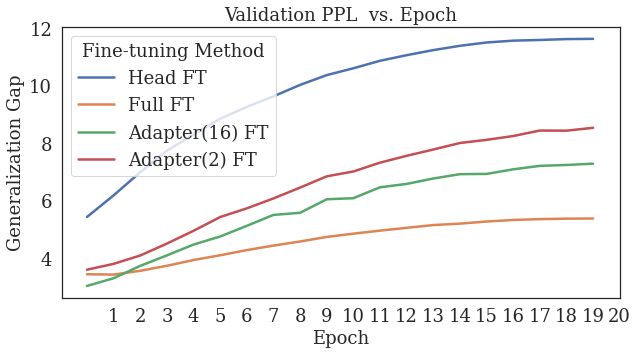

In [146]:

ylabel = 'Generalization Gap'
xlabel='Epoch'
title = 'Validation PPL  vs. Epoch'
var = 'gen_gap'
f_name ='wikipedia-gengap-epoch.pdf'

plot_linear(xlabel,ylabel,title,var,data_mia_head,data_mia_full,data_mia_adapter,data_mia_adapter_red2,f_name)



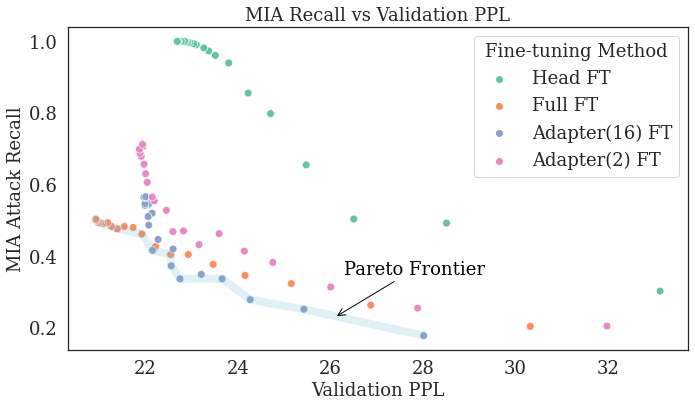

In [150]:
#data = {'X': [13, 13, 13, 12, 11], 'Y':[14, 11, 13, 15, 20], 'NumberOfPlanets':[2, 5, 2, 1, 2]}
#cts = pd.DataFrame(data=data)


df_all['Validation PPL'] =df_all['valperp']
df_all['MIA Attack Recall'] = df_all['attack1']

xlabel = 'Validation PPL'
ylabel = 'MIA Attack Recall'
hue = 'hue'
legendtitle = 'Fine-tuning Method'
title= 'MIA Recall vs Validation PPL'
f_name ='ptb-mia-valppl-scatter-pareto.pdf'
plot_scatter(xlabel,ylabel,title,hue,legendtitle,df_all,f_name,pareto=True, xy=(26.1,0.23), xytext=(26.3,0.35))


# p_front = pareto_frontier(list(df_all['valperp']), list(df_all['attack1']), maxX = False, maxY = False) 
# #df_all['sum'] = df_all['attack1'] +df_all['valperp']

# #cts = df_all.sort_values('sum')

# plt.figure(figsize=(10,6), tight_layout=True)
# ax = sns.scatterplot(data=df_all, x=xlabel, y=ylabel,hue=hue, palette='Set2', s=60)
# ax.set(xlabel=xlabel,title=title, ylabel=ylabel)
# ax.legend(title=legendtitle, title_fontsize = 12) 

# # plt.figure(figsize=(10,10))
# # plt.scatter(cts['valperp'], cts['attack1'], zorder=1)
# plt.plot(p_front[0], p_front[1], zorder=2, linewidth=8, color='c', alpha=0.2)
# plt.savefig(f_name, transparent=True)
# plt.show()

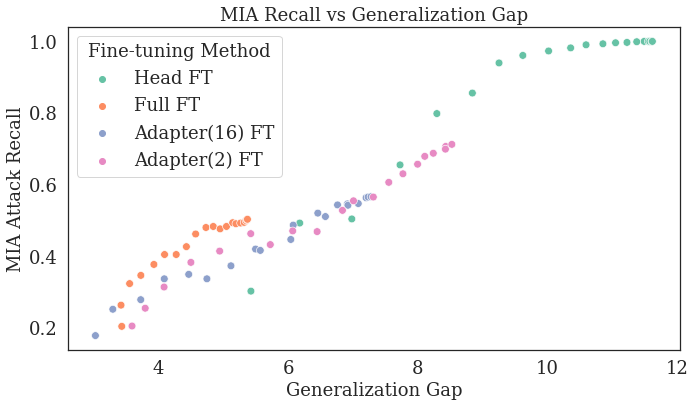

In [151]:

df_all['Generalization Gap'] =df_all['gen_gap']
df_all['MIA Attack Recall'] = df_all['attack1']

xlabel = 'Generalization Gap'
ylabel = 'MIA Attack Recall'


hue = 'hue'
legendtitle = 'Fine-tuning Method'
title= 'MIA Recall vs Generalization Gap'

f_name ='ptb-mia-gengap-scatter.pdf'

plot_scatter(xlabel,ylabel,title,hue,legendtitle,df_all,f_name)


In [154]:
data_mia_head = get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/ptb/logs/canary_25_6_adapter_False_head_True_layer_None_ref_False_maxlen_1024_red_None_model_gpt2_lr_0.0005_epoch_20_trba_1_acc_8_evba1_data_ptb_text_only/stdout',hue='Head FT')
data_mia_full=  get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/ptb/logs/canary_25_6_adapter_False_head_False_layer_None_ref_False_maxlen_1024_red_None_model_gpt2_lr_5e-05_epoch_20_trba_1_acc_8_evba1_data_ptb_text_only/stdout', hue = 'Full FT',old=False)
data_mia_adapter=  get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/ptb/logs/canary_25_6_adapter_True_head_False_layer_None_ref_False_maxlen_1024_red_16_model_gpt2_lr_0.001_epoch_20_trba_1_acc_8_evba1_data_ptb_text_only/stdout', hue = 'Adapter(16) FT',old=False)
data_mia_adapter_red2=  get_data_exposure('/home/fmireshg/berglab.projects/efficient_ft/gen/ptb/logs/canary_25_6_adapter_False_head_True_layer_None_ref_False_maxlen_1024_red_None_model_gpt2_lr_0.0002_epoch_20_trba_1_acc_8_evba1_data_ptb_text_only/stdout', hue = 'Adapter(2) FT',old=False)

df_head = pd.DataFrame.from_dict(data_mia_head)
df_full = pd.DataFrame.from_dict(data_mia_full)
df_adapter = pd.DataFrame.from_dict(data_mia_adapter)
df_adapter_red2 = pd.DataFrame.from_dict(data_mia_adapter_red2)

df_all= pd.concat([df_head, df_full,df_adapter,df_adapter_red2], axis=0)
#data_exposure = get_data_exposure('/home/tr33/Documents/efficient_ft/gen/stdout-exposure')         